# Flow Over Cylinder

The simulation of a high Reynolds flow around a circular cylinder is used as validation for the HRRBGK collision operator implementation, the case is the same used in [Jacob et al., 2018](https://doi.org/10.1080/14685248.2018.1540879). The dynamic implementation of the tuning parameter is expected to provide more accurate results of velocity profiles for the HRRBGK in comparison to RRBGK.

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/09_flow_over_cylinder.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

The computational domain is periodic at $y$-direction, uses free slip BCs in $z$-direction, uniform velocity at inlet and Neumann with constant pressure at outlet.

Load experimental values for comparison:

In [2]:
import pandas as pd
import pathlib

comparison_folder = "tests/validation/comparison/Flow_over_cylinder"
files = [
    "ux_avg_upstream",
    "ux_rms_upstream",
    "ux_avg_102D",
    "ux_rms_102D",
    "uz_avg_102D",
    "uz_rms_102D",
    "ux_avg_154D",
    "ux_rms_154D",
    "uz_avg_154D",
    "uz_rms_154D",
    "ux_avg_202D",
    "ux_rms_202D",
    "uz_avg_202D",
    "uz_rms_202D",
]
get_filename_csv = lambda f: pathlib.Path(comparison_folder) / (f + ".csv")


df_vel = {f: pd.read_csv(get_filename_csv(f), delimiter=",") for f in files}

## Results

In [3]:
import numpy as np
import pandas as pd
from nassu.cfg.schemes.simul import SimulationConfigs

u_ref = 0.0585


def add_pos_to_points(df_points: pd.DataFrame, start_pos: float, end_pos: float):
    df_points["pos"] = np.linspace(start_pos, end_pos, num=len(df_points), endpoint=True)


def add_stats_to_points(df_points: pd.DataFrame, df_hs: dict[str, pd.DataFrame]):
    df_data = {k: df.drop(columns=["time_step"]) for k, df in df_hs.items()}
    for u_name in ["ux", "uy", "uz"]:
        df_points[f"{u_name}_avg"] = (df_data[u_name].mean() / u_ref).to_numpy(dtype=np.float32)
        df_points[f"{u_name}_rms"] = ((df_data[u_name].std() ** 2) / (u_ref**2)).to_numpy(
            np.float32
        )


def read_hs(sim_cfg: SimulationConfigs, line_name: str):
    line_ref = sim_cfg.output.series["default"].lines[line_name]
    df_points = pd.read_csv(line_ref.points_filename)
    df_hs = {u: line_ref.read_full_data(u) for u in ["ux", "uy", "uz"]}
    return (line_ref, df_points, df_hs)

Read experimental lines and add data

In [4]:
lines = {
    "upstream": {"start_pos": 0.5, "end_pos": 6.5},
    "line_102": {"start_pos": -1.5, "end_pos": 1.5},
    "line_154": {"start_pos": -1.5, "end_pos": 1.5},
    "line_202": {"start_pos": -1.5, "end_pos": 1.5},
}


def get_lines_from_sim(sim_cfg: SimulationConfigs):
    dct_sim_cfg = {}
    for line_name, dct_line in lines.items():
        hs, df_points, df_hs = read_hs(sim_cfg, line_name)
        # Filter time steps
        df_hs = {u: df[df["time_step"] > 6000] for u, df in df_hs.items()}
        # df_hs = df_hs[df_hs["time_step"] < 10000]

        add_pos_to_points(df_points, dct_line["start_pos"], dct_line["end_pos"])
        add_stats_to_points(df_points, df_hs)
        dct_sim_cfg[line_name] = {"hs": hs, "df_points": df_points}
    return dct_sim_cfg


sim_cfgs_lines = [get_lines_from_sim(sim_cfg) for sim_cfg in sim_cfgs.values()]

Set styles and legends for plots

In [5]:
lg = [f"{s.models.LBM.vel_set} {s.models.LBM.coll_oper}" for s in sim_cfgs.values()]

num_styles = ["-k", "-r", "-b", "-m", "-c"]
exp_style = "ko"

In [6]:
def plot_line_values(ax, line_name: str, vel_name: str, exp_filename: str):
    for i, sim_lines in enumerate(sim_cfgs_lines):
        df_points = sim_lines[line_name]["df_points"]
        ax.plot(df_points["pos"], df_points[vel_name], num_styles[i])
    df_exp = df_vel[exp_filename]
    ax.plot(df_exp.iloc[:, 0], df_exp.iloc[:, 1], exp_style, fillstyle="none")
    ax.legend(lg + ["Exp."])

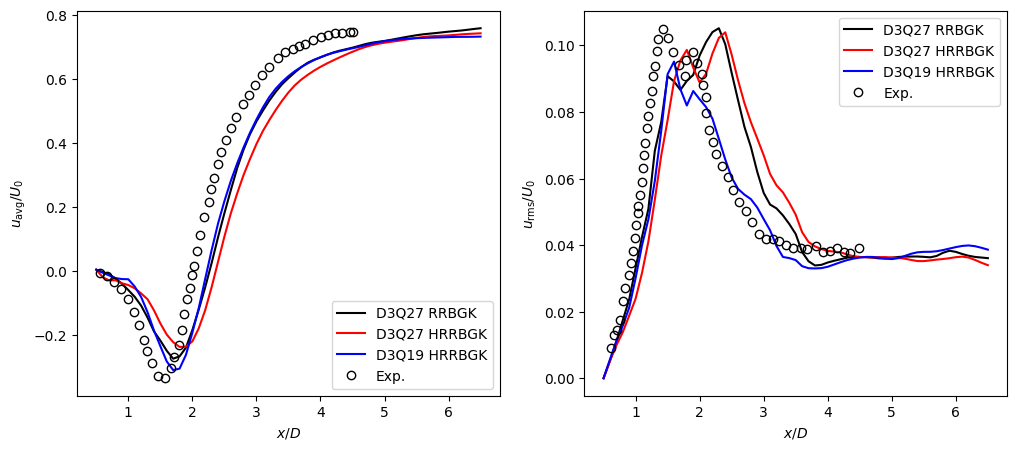

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

plot_line_values(ax[0], "upstream", "ux_avg", "ux_avg_upstream")
ax[0].set_ylabel("$u_{\mathrm{avg}}/U_{0}$")
ax[0].set_xlabel("$x/D$")


plot_line_values(ax[1], "upstream", "ux_rms", "ux_rms_upstream")
ax[1].set_ylabel("$u_{\mathrm{rms}}/U_{0}$")
ax[1].set_xlabel("$x/D$")

plt.show(fig)

In [8]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(12, 18)

for i, dist in enumerate([102, 154, 202]):
    plot_line_values(ax[i][0], f"line_{dist}", "ux_avg", f"ux_avg_{dist}D")
    ax[i][0].set_ylabel("$u_{\mathrm{avg}}/U_{0}$")
    ax[i][0].set_xlabel("$z/D$")
    ax[i][0].set_title(f"{dist/100:.2f}D $u$")

    plot_line_values(ax[i][1], f"line_{dist}", "ux_rms", f"ux_rms_{dist}D")
    ax[i][1].set_ylabel("$u_{\mathrm{rms}}/U_{0}$")
    ax[i][1].set_xlabel("$z/D$")
    ax[i][1].set_title(f"{dist/100:.2f}D $u$")

plt.show(fig)

In [9]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(12, 18)

for i, dist in enumerate([102, 154, 202]):
    plot_line_values(ax[i][0], f"line_{dist}", "uz_avg", f"uz_avg_{dist}D")
    ax[i][0].set_ylabel("$w_{\mathrm{avg}}/U_{0}$")
    ax[i][0].set_xlabel("$z/D$")
    ax[i][0].set_title(f"{dist/100:.2f}D $w$")

    plot_line_values(ax[i][1], f"line_{dist}", "uz_rms", f"uz_rms_{dist}D")
    ax[i][1].set_ylabel("$w_{\mathrm{rms}}/U_{0}$")
    ax[i][1].set_xlabel("$z/D$")
    ax[i][1].set_title(f"{dist/100:.2f}D $w$")

plt.show(fig)

## Version

In [10]:
sim_cfg = next(iter(sim_cfgs.values()))
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: cab6b7ad2a955ba7656e05b10c2cee0c8f0fdad4


## Configuration

In [11]:
from IPython.display import Code

Code(filename=filename)

simulations:
  - name: flowOverCylinder
    save_path: ./tests/validation/results/09_flow_over_cylinder

    n_steps: 20000

    report: { frequency: 100 }

    domain:
      domain_size:
        x: 160
        y: 8
        z: 80
      block_size: 8
      bodies:
        cylinder:
          IBM:
            run: True
            cfg_use: cylinder_cfg
          lnas_path: fixture/lnas/basic/cylinder_refined.lnas
          small_triangles: "add"
          area: { min: 0.25, max: 1.0 }
          transformation:
            scale: [1.0, 1.0, 1.0]
            translation: [23.75, -24, 38.75]
      refinement:
        static:
          default:
            volumes_refine:
              - start: [20, 0, 16]
                end: [160, 8, 64]
                lvl: 1
                is_abs: true
              - start: [20, 0, 24]
                end: [80, 8, 56]
                lvl: 2
                is_abs: true
              - start: [20, 0, 32]
                end: [48, 8, 48]
                lvl: 3
                is_abs: true
              - start: [20, 0, 36]
                end: [34, 8, 44]
                lvl: 4
                is_abs: true
              - start: [23, 0, 38]
                end: [30, 8, 42]
                lvl: 5
                is_abs: true

    data:
      divergence: { frequency: 10 }
      instantaneous:
        default: { interval: { frequency: 1000 }, macrs: [rho, u, omega_LES, sigma] }
      export_IBM_nodes: { frequency: 5000 }
      probes:
        historic_series:
          default:
            macrs: ["rho", "u"]
            interval: { frequency: 10, lvl: 5 }
            lines:
              upstream:
                dist: 0.25
                start_pos: [26.25, 4, 40]
                end_pos: [41.25, 4, 40]
              line_102:
                dist: 0.25
                start_pos: [27.65, 4, 36.25]
                end_pos: [27.65, 4, 43.75]
              line_154:
                dist: 0.25
                start_pos: [28.85, 4, 36.25]
                end_pos: [28.85, 4, 43.75]
              line_202:
                dist: 0.25
                start_pos: [30.05, 4, 36.25]
                end_pos: [30.05, 4, 43.75]
        spectrum_analysis:
          macrs: ["rho", "u"]
          points:
            probe:
              pos: [32.5, 4, 40]

    models:
      precision:
        default: single

      LBM:
        tau: 0.5001125
        vel_set: !unroll [D3Q27, D3Q27, D3Q19]
        coll_oper: !unroll [RRBGK, HRRBGK, HRRBGK]

      initialization:
        rho: 1.0
        u:
          x: 0.0585
          y: 0
          z: 0

      engine:
        name: CUDA

      BC:
        periodic_dims: [false, true, false]
        BC_map:
          - pos: F
            BC: Neumann
            wall_normal: F
            order: 1

          - pos: B
            BC: Neumann
            wall_normal: B
            order: 1

          - pos: E
            BC: RegularizedNeumannOutlet
            rho: 1.0
            wall_normal: E
            order: 2

          - pos: W
            BC: UniformFlow
            wall_normal: W
            ux: 0.0585
            uy: 0
            uz: 0
            rho: 1
            order: 2

          - pos: NF
            BC: Neumann
            wall_normal: F
            order: 1

          - pos: NB
            BC: Neumann
            wall_normal: B
            order: 1

          - pos: SF
            BC: Neumann
            wall_normal: F
            order: 1

          - pos: SB
            BC: Neumann
            wall_normal: B
            order: 1

      IBM:
        dirac_delta: 3_points
        forces_accomodate_time: 0
        reset_forces: true
        body_cfgs:
          cylinder_cfg:
            n_iterations: 3
            forces_factor: 0.5
            wall_model:
              name: EqTBL
              dist_ref: 3.125
              dist_shell: 0.125
              start_step: 0
              params:
                z0: 0.00155
                TDMA_max_error: 1e-04
       